In [1]:
#This notebook will explore the loss landscape of mnist for different types of architectures and activation functions
#The goal of this notebook is to rationalize SWA

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# load MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# scale all input values between 0 and 1
# This is normalizes the data and reduces the amount of variance in gray color 
X_train = X_train /255.
X_test = X_test / 255.

In [3]:
from layer_rotation_control import SGD, Adagrad, Adam
from layer_rotation_monitoring import LayerRotationCurves

def model(lr=3e-3, h_l=2, units=10, layca = True):
    inputs = keras.layers.Input(shape=(28,28))
    flatten = keras.layers.Flatten()(inputs)
    dense = keras.layers.Dense(units, activation=keras.layers.LeakyReLU(alpha=0.3), use_bias=False)(flatten)
    for _ in range(int(h_l - 1)):
        dense = keras.layers.Dense(units, activation=keras.layers.LeakyReLU(alpha=0.3), use_bias=False)(dense)
    output = keras.layers.Dense(10, activation="softmax", use_bias=False)(dense)
    
    opt = Adam(lr, layca = layca)
    model = keras.Model(inputs=inputs,outputs=output)
    model.compile(optimizer=opt, loss=["categorical_crossentropy"], metrics=['accuracy'])
    model.summary()
    return model

def train(model, ep=2):
    lrc = LayerRotationCurves()
    history = model.fit(X_train, y_train, epochs=ep, validation_data=(X_test,y_test), callbacks = [lrc])
    
    # plot layer rotation curves
    plt.figure()
    lrc.plot()
    

/anaconda3/envs/venv/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10000     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10000     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
Train 

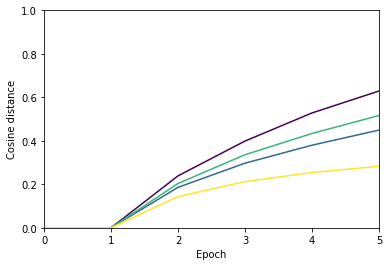

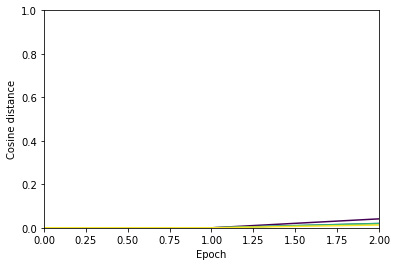

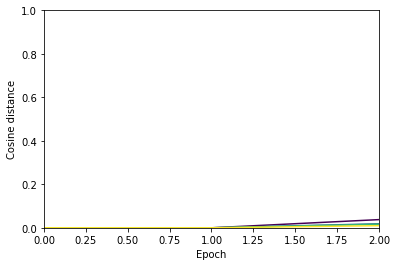

In [4]:

#Independent optimum

"""
m1 = model(layca=False)
m2 = model(layca=False)
m3 = model(layca=False)
train(m1, ep=10)
train(m2, ep=10)
train(m3, ep=10)
w0 = np.array(m3.get_weights())
m1_weights = np.array(m1.get_weights())
m2_weights = np.array(m2.get_weights())
"""
hidden_layers = 3
hidden_units = 100
#Dependent Optimum
m1 = model(h_l=hidden_layers, units=hidden_units, layca=True)
#m2 = model(layca=False)
#m3 = model()
train(m1, ep=5)
w0 = np.array(m1.get_weights())
train(m1, ep=2)
m1_weights = np.array(m1.get_weights())
train(m1, ep=2)
m2_weights = np.array(m1.get_weights())



In [5]:
def landscape(w0, w1, w2, x_min=-0.5, x_max=2.0, res=19):
    rang= x_max-x_min
    loss_landscape = np.zeros((res+1, res+1))
    acc_landscape = np.zeros((res+1, res+1))
    lin_model = model(h_l=hidden_layers, units=hidden_units)
    
    for i in range(res + 1):
        w1_i = (rang*(i/res)+ x_min)*w1
        for k in range(res + 1):
            w2_k = (rang*(k/res)+ x_min)*w2
            lin = w1_i + w2_k + w0
            lin_weights = list()
            for weight in lin:
                lin_weights.append(weight)

            lin_model.set_weights(lin_weights)
            loss = lin_model.evaluate(X_test[:1000], y_test[:1000])
            loss_landscape[i][k] = loss[0]
            acc_landscape[i][k] = loss[1]
    
    return loss_landscape, acc_landscape


In [6]:
l1, a1 = landscape(w0, m1_weights, m2_weights)
l2, a2 = landscape(m2_weights, w0, m1_weights)
l3, a3 = landscape(m1_weights, m2_weights, w0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78400     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10000     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10000     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
1000/1

1000/1000 [==============================] - 0s 31us/step


1000/1000 [==============================] - 0s 23us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               78400     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
______________

1000/1000 [==============================] - 0s 24us/step


1000/1000 [==============================] - 0s 22us/step


1000/1000 [==============================] - 0s 31us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
______________

1000/1000 [==============================] - 0s 25us/step


1000/1000 [==============================] - 0s 39us/step


1000/1000 [==============================] - 0s 23us/step


In [7]:
def plot_landscape(l, a):
    plt.title("Log of Loss Landscape")
    plt.imshow(np.log(l), origin="lower")
    plt.show()
    plt.title("Accuracy Landscape")
    plt.imshow(np.exp(a), origin="lower")
    plt.show()

def best_weight(l, w0, w1, w2, x_min=-0.5, x_max=2.0, res=19):
    rang= x_max-x_min
    #Extract the best model
    max_index = np.unravel_index(l.argmin(), l.shape)
    print(max_index)

    best_weights = w0 + (rang*(max_index[0]/res) + x_min)*w1 + (rang*(max_index[1]/res) + x_min)*w2
    lin_weights = list()
    for weight in best_weights:
        lin_weights.append(weight)
    
    return lin_weights
    

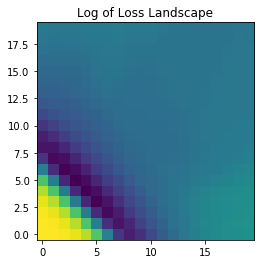

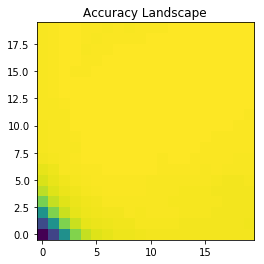

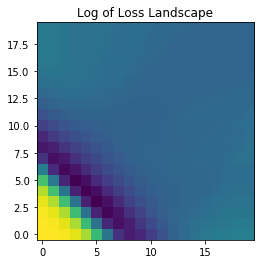

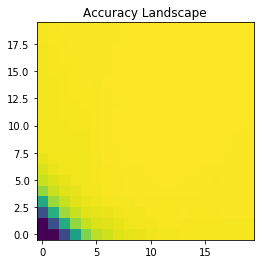

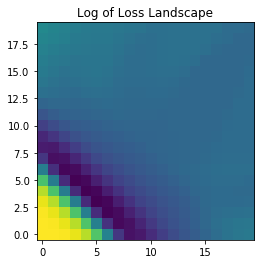

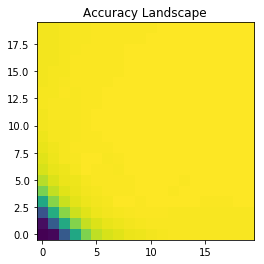

In [8]:
plot_landscape(l1, a1)
plot_landscape(l2, a2)
plot_landscape(l3, a3)

In [9]:
b1 = best_weight(l1, w0, m1_weights, m2_weights)
b2 = best_weight(l2, m2_weights, w0, m1_weights)
b3 = best_weight(l3, m1_weights, m2_weights, w0)

best = [b1, b2, b3]

for b in best:
    lin_model = model(h_l=hidden_layers, units=hidden_units)
    lin_model.set_weights(b)
    loss = lin_model.evaluate(X_test, y_test)
    print("Test: ", loss)
    loss = lin_model.evaluate(X_train, y_train)
    print("Training: ", loss)

(5, 3)
(4, 4)
(4, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
___________________________________________________

In [10]:
lf, af = landscape(w0, (m1_weights - w0), (m2_weights - w0), x_min=0.0, x_max=2.0, res=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
1000/1

1000/1000 [==============================] - 0s 24us/step


1000/1000 [==============================] - 0s 25us/step


1000/1000 [==============================] - 0s 24us/step


1000/1000 [==============================] - 0s 27us/step


1000/1000 [==============================] - 0s 31us/step


1000/1000 [==============================] - 0s 27us/step


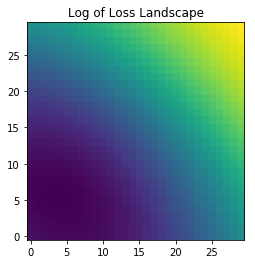

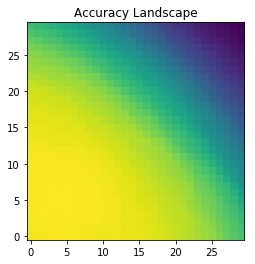

In [11]:
plot_landscape(lf, af)

In [12]:
bf = best_weight(lf, w0, (m1_weights - w0), (m2_weights - w0), x_min=0.0, x_max=1.0, res=29)

(5, 4)


In [13]:
lin_model = model(h_l=hidden_layers, units=hidden_units)
lin_model.set_weights(bf)
loss = lin_model.evaluate(X_test, y_test)
print("Test: ", loss)
loss = lin_model.evaluate(X_train, y_train)
print("Training: ", loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
10000/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_40 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
1000/1

1000/1000 [==============================] - 0s 28us/step


1000/1000 [==============================] - 0s 25us/step


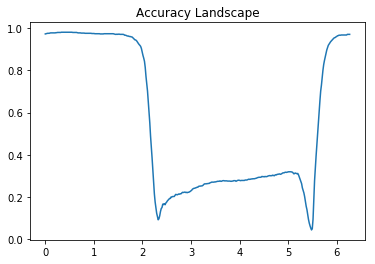

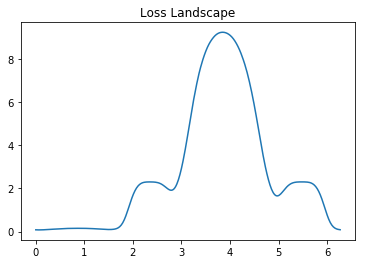

In [14]:
#Felizarta's hypothesis, search unit c
res = 400
t_end = 3.1415
t_start = 0
lin_model = model(h_l=hidden_layers, units=hidden_units, layca=True)

t_axis = []
loss_landscape = []
acc_landscape = []

for t in range(res):
    s = (t/res)*(t_end*2) #PI/2 for only positive x and y
    x = np.cos(s)
    y = np.sin(s)
    lin = x*w0 + y*m2_weights
    lin_weights = list()
    for weight in lin:
        lin_weights.append(weight)

    lin_model.set_weights(lin_weights)
    loss = lin_model.evaluate(X_test[:1000], y_test[:1000])
    loss_landscape.append(loss[0])
    acc_landscape.append(loss[1])
    t_axis.append(s)
    
plt.title("Accuracy Landscape")
plt.plot(t_axis, acc_landscape)
plt.show()
plt.title("Loss Landscape")
plt.plot(t_axis, loss_landscape)
plt.show()



    

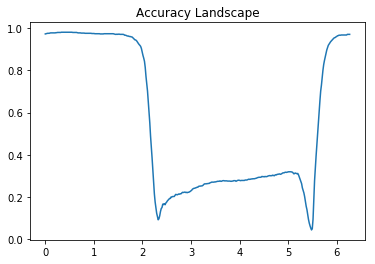

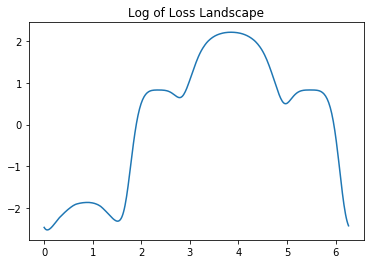

In [15]:
plt.title("Accuracy Landscape")
plt.plot(t_axis, acc_landscape)
plt.show()
plt.title("Log of Loss Landscape")
plt.plot(t_axis, np.log(loss_landscape))
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_44 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
1000/1

1000/1000 [==============================] - 0s 29us/step


1000/1000 [==============================] - 0s 27us/step


1000/1000 [==============================] - 0s 29us/step


1000/1000 [==============================] - 0s 27us/step


1000/1000 [==============================] - 0s 25us/step


1000/1000 [==============================] - 0s 28us/step


1000/1000 [==============================] - 0s 24us/step


1000/1000 [==============================] - 0s 31us/step


1000/1000 [==============================] - 0s 29us/step


1000/1000 [==============================] - 0s 26us/step


1000/1000 [==============================] - 0s 24us/step


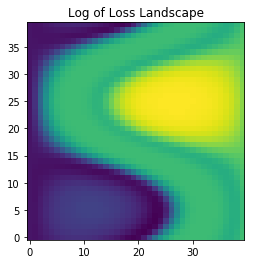

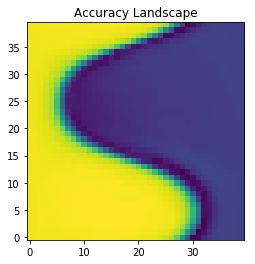

In [16]:
#Felizarta's hypothesis, search unit c
res = 40
t_end = 3.1415
t_start = 0
lin_model = model(h_l=hidden_layers, units=hidden_units)

loss_landscape = np.zeros((res, res))
acc_landscape = np.zeros((res, res))

for alpha in range(res):
    theta = (alpha/res)*(t_end*2)
    for beta in range(res):
        phi = (beta/res)*(t_end) #PI/2 for only positive x and y
        x = np.sin(phi)*np.cos(theta)
        y = np.sin(phi)*np.sin(theta)
        z = np.cos(phi)
        
        lin = x*w0 + y*m1_weights + z*m2_weights
        lin_weights = list()
        for weight in lin:
            lin_weights.append(weight)

        lin_model.set_weights(lin_weights)
        loss = lin_model.evaluate(X_test[:1000], y_test[:1000])
        loss_landscape[alpha][beta] = loss[0]
        acc_landscape[alpha][beta] = loss[1]
        
    
plot_landscape(loss_landscape, acc_landscape)

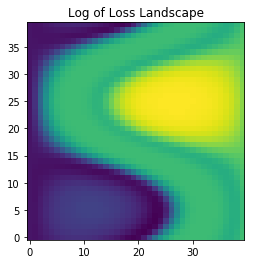

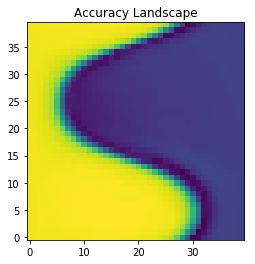

In [17]:
plot_landscape(loss_landscape, acc_landscape)

In [18]:
lin_model = model(h_l=hidden_layers, units=hidden_units)
rang= 3.1415
#Extract the best model
max_index = np.unravel_index(acc_landscape.argmax(), acc_landscape.shape)
theta = (max_index[0]/res)*(t_end*2)
phi = (max_index[1]/res)*(t_end)

x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

print(((theta/(2*3.1415)) * res, res*phi/3.1415))
print((x,y,z))
best_weights = x*w0 + y*m1_weights + z*m2_weights
lin_weights = list()
for weight in best_weights:
    lin_weights.append(weight)
    
lin_model.set_weights(lin_weights)
loss = lin_model.evaluate(X_test, y_test)
print("Test: ", loss)
loss = lin_model.evaluate(X_train, y_train)
print("Training: ", loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_48 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
(3.0, 

In [19]:
dist = best_weights - w0
distance = 0
for weight in dist:
    distance += np.sum(np.square(weight))
    
print(np.sqrt(distance))

13.827959100622506


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
1000/1

1000/1000 [==============================] - 0s 26us/step


1000/1000 [==============================] - 0s 27us/step


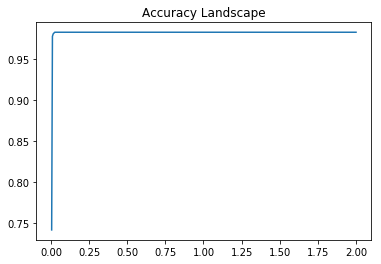

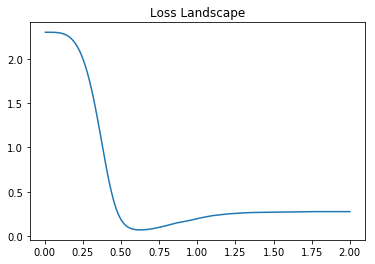

In [20]:
#Line search or better loss?!
res = 400
alpha_min = 0.0
alpha_max = 2.0

lin_model = model(h_l=hidden_layers, units=hidden_units)

alpha_axis = []
loss_landscape = []
acc_landscape = []

for t in range(res):
    alpha = ((t+1)/res)*(alpha_max-alpha_min)
    lin = alpha*best_weights
    lin_weights = list()
    for weight in lin:
        lin_weights.append(weight)

    lin_model.set_weights(lin_weights)
    loss = lin_model.evaluate(X_test[:1000], y_test[:1000])
    loss_landscape.append(loss[0])
    acc_landscape.append(loss[1])
    alpha_axis.append(alpha)
    
plt.title("Accuracy Landscape")
plt.plot(alpha_axis, acc_landscape)
plt.show()
plt.title("Loss Landscape")
plt.plot(alpha_axis, loss_landscape)
plt.show()

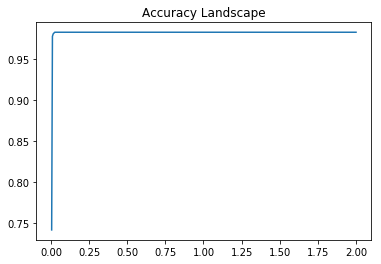

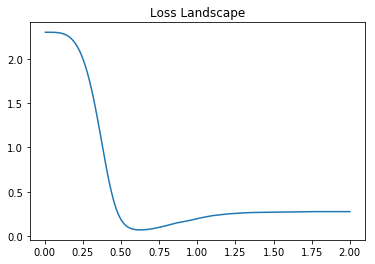

In [21]:
plt.title("Accuracy Landscape")
plt.plot(alpha_axis, acc_landscape)
plt.show()
plt.title("Loss Landscape")
plt.plot(alpha_axis, loss_landscape)
plt.show()

In [22]:
#Reconstruct the lowest loss, best accuracy
SIT_model = model(h_l=hidden_layers, units=hidden_units)
best_index = np.argmin(loss_landscape)
best_coeff = alpha_axis[best_index]
super_weights = best_coeff*best_weights
lin_weights = list()
for weight in super_weights:
    lin_weights.append(weight)
    
SIT_model.set_weights(lin_weights)
loss = SIT_model.evaluate(X_test, y_test)
print("Test: ", loss)
loss = SIT_model.evaluate(X_train, y_train)
print("Training: ", loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28, 28)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               78400     
_________________________________________________________________
dense_54 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10000     
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1000      
Total params: 99,400
Trainable params: 99,400
Non-trainable params: 0
_________________________________________________________________
10000/